In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import ctypes as ct
import scipy.interpolate
from aerofiles.igc import Reader



import plotly.graph_objects as go

import pandas as pd





In [2]:
# Function to read airfoil data at each station

def GetAirfoilData(Filename):
    with open(Filename, 'r') as infile:
        AirfoilData = np.loadtxt(infile, dtype=str, skiprows=0, unpack=True)
    
    return AirfoilData

In [3]:
# Function to read wing geometry

def GetWingData(Filename):
    with open(Filename, 'r') as infile:
        WingData = np.loadtxt(infile, dtype=float, skiprows=0, unpack=True)
    area = 0
    span = 0
    
    for i in range(0,len(WingData[0]),1):
        span = span + WingData[2][i]
        area = area + ((WingData[0][i] + WingData[1][i])/2)*WingData[2][i]
    
    AR = 2*(span**2)/area
    
    return area, span,AR,WingData
    



In [38]:
def CallXfoilcl(Cl, Re, AirfoilName, Flap):

    mydll = ct.cdll.LoadLibrary("./XFOIL.dll")

    ISCONV = ct.c_bool(False)
    RE_IN = ct.c_double(Re)
    CL_IN = ct.c_double(Cl)
    array = (ct.c_double * 11) (0,0,0,0,0,0,0,Flap,0.86,-0.008,0)
#FileName = 'D:\XFOIL\T12'


    my_string = AirfoilName.encode() # Convert string to bytes



    _= mydll.xfoil_cl(ct.byref(array), ct.byref(CL_IN),ct.byref(RE_IN),ct.byref(ISCONV),ct.c_char_p(my_string))

            # Array1(1) = ADEG
            # Array1(2) = CD
            # Array1(3) = CDF
            # Array1(4) = CM
            # Array1(5) = HMOM
            # Array1(6) = HFX
            # Array1(7) = HFY
    print(ISCONV.value)         #[uncomment if you want to see whether iteration for station has converged]
    return array[0],array[1],array[3]        
                

In [5]:
#SAMPLE CODE

Area,Span,AR, WingData = GetWingData("JS4_wing_15m.dat")
print(WingData)
print("Number of panels => " + str(WingData[0].size))
print("Aspect Ratio => " + str(AR))
print("Area => " + str(Area*2))
print("Span => " + str(Span*2))
#print(dir(WingData))

[[0.82   0.8    0.7    0.535  0.419 ]
 [0.8    0.7    0.535  0.419  0.21  ]
 [2.2    1.98   1.8    0.89   0.67  ]
 [1.     1.072  1.156  1.2045 1.1185]
 [1.072  1.156  1.2045 1.1185 1.    ]]
Number of panels => 5
Aspect Ratio => 22.678297360555824
Area => 10.027490000000002
Span => 15.079999999999998


In [6]:
rho = 1.225
mu = 1.789e-5
V_inf = 30


In [ ]:
#SAMPLE CODE


AirfoilData  = GetAirfoilData("JS4_Airfoil_Data.dat")
print(AirfoilData)


for i in range(0,len(AirfoilData[0]),1):
    Re = rho*V_inf*float(AirfoilData[1][i])/mu
    
    # call XFOIL DLL
    #AOA, Cd,Cm = CallXfoilcl(0,Re,AirfoilData[0][i],0)
    #print(i+1,AirfoilData[1][i],Re,AOA, Cd, Cm)
    

In [8]:
# Function to divide wing into n sections, returns chord lengths array
#NOT USED


def WingDivide(WingData,n):
    number_of_panels = WingData[0].size

    #determine wing span from wing file
    span = 0
    if number_of_panels > 1:
        for panel_length in WingData[5]:
            span = span + panel_length 
    else:
        span = WingData[5]
        
    #print("Wing span => " + str(2*span))
    
    
    # divide wing into n sections
    chords = np.zeros(n, dtype=float)
    current_panel = 0 
    current_span_pos = WingData[5][0]
    i = 0
    for y_pos in np.linspace(0,span, n):
           
        if y_pos > current_span_pos:
            current_panel = current_panel + 1
            current_span_pos = current_span_pos + WingData[5][current_panel]
        
        chords[i] = ((WingData[0][current_panel] - WingData[1][current_panel]) / WingData[5][current_panel]) * (current_span_pos - y_pos) + WingData[1][current_panel]
        i += 1
    #print(np.stack((np.linspace(0,span,n),chords),axis=1))    
    return(np.stack((np.linspace(0,span,n),chords),axis=1))
 
    
    

In [9]:
def Get_Chord(WingData,y_pos):
    chord = 0
    number_of_panels = WingData[0].size

    #determine wing span from wing file
    span = 0
    if number_of_panels > 1:
        for panel_length in WingData[2]:
            span = span + panel_length 
    else:
        span = WingData[2]
        
    #print("Wing half span => " + str(span))
    
    
   
   
    current_panel = 0
    current_span_pos = WingData[2][0]   #outer section of current panel
     
    while current_panel <= number_of_panels+1:
        if y_pos < current_span_pos:
                chord = ((WingData[0][current_panel] - WingData[1][current_panel]) / WingData[2][current_panel]) * (current_span_pos - y_pos) + WingData[1][current_panel]
                break
        
        current_panel += 1 
        current_span_pos = current_span_pos + WingData[2][current_panel]
               
        #print(current_panel,current_span_pos)
        
    
    
    #print(np.stack((np.linspace(0,span,n),chords),axis=1))    
    return(chord)

In [10]:
def Solve_LL(wingdata,span,AR,alpha,a,n):
    
    #a is the lift slope cl/radians  -> 2*PI
    
    theta_range = np.linspace(90,0.01,n)
    AMatrix = np.ones(shape=(n,n))
    X = np.ones(n)
    delta = 0
    Cl = np.zeros(n)
    y_pos = np.zeros(n)
    
    
    i = 0
    for theta in theta_range:
        unit_y = -math.cos(np.deg2rad(theta)) 
        c = Get_Chord(wingdata,-unit_y*span)
        mu = c*a/(8*span)
        
        X[i] = mu*(np.deg2rad(alpha))*(math.sin(np.deg2rad(theta)))
        for j in range(0,n,1):
            AMatrix[i][j] = (math.sin(((j+1)*2 -1)*np.deg2rad(theta)))*(((j+1)*2-1)*mu + (math.sin(np.deg2rad(theta))))
        
        y_pos[i] = -unit_y*span
        i+=1
    
    #print(A)
    #print(X)      
    #A = np.matmul(np.linalg.inv(AMatrix),X)
    A = np.linalg.solve(AMatrix, X)
    
    
    for i in range(1,n,1):
        delta = delta +((i+1)*2-1)*(A[i]**2)/(A[0]**2)

    #e =  (1/(1+delta))     

    k = 0
    for theta in theta_range:  
        for j in range(0,n,1):
            unit_y = -math.cos(np.deg2rad(theta))
            c = Get_Chord(wingdata,-unit_y*span)
            Cl[k] = Cl[k]+ (8*span)*(A[j]*(math.sin(((j+1)*2-1)*np.deg2rad(theta)))) / c
            
        k+=1
           
    CL = A[0]*(np.pi)*AR
    Cl_unit = Cl/CL
    return(Cl_unit,y_pos,CL,delta) 
          
    

Span efficiency delta => 0.020374621855408743
CL => 0.515664194792368


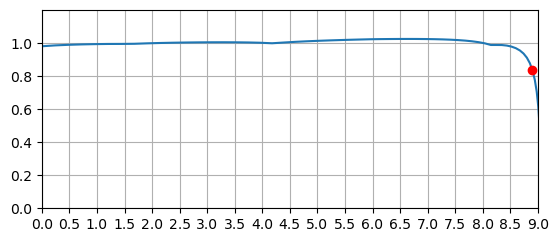

In [11]:
# SAMPLE CODE

n = 60
a = 2*np.pi
alpha = 5

Area,Span,AR, WingData = GetWingData("wing_18.dat")
Cl,y_pos,CL,Delta = Solve_LL(WingData,Span,AR,alpha,a,n)   

print("Span efficiency delta => " + str(Delta))  


print("CL => " + str(CL))
#print(Cl)                    #Unit local Cl distribution
#print(y_pos)                 #span position for each local lift coefficient)


fig, ax = plt.subplots()
ax.set(xlim=(0, 9), xticks=np.arange(0, 9.5,0.5),
       ylim=(0, 1.2), yticks=np.arange(0, 1.2,0.2))
ax.plot(y_pos, Cl)
Cl_interp = scipy.interpolate.interp1d(y_pos,Cl)
spanpoint = 8.9
ax.plot(spanpoint,Cl_interp(spanpoint),'ro')
ax.grid(True)
ax.set_box_aspect(0.4)
plt.show()



In [12]:
def Standard_Atmosphere(FileName,Elevation, standard_rho):
    
    with open(FileName, 'r') as infile:
        S_atm_Data = np.loadtxt(infile, dtype=float, skiprows=1, unpack=True)
    
    
    pressure_interp = scipy.interpolate.interp1d(S_atm_Data[0],S_atm_Data[2])
    density_interp = scipy.interpolate.interp1d(S_atm_Data[0],S_atm_Data[3])
    Kin_viscosity_interp = scipy.interpolate.interp1d(S_atm_Data[0],S_atm_Data[4])
   
    pressure = pressure_interp(Elevation)
    rho = standard_rho* density_interp(Elevation)
    mu = rho * Kin_viscosity_interp(Elevation)* 1e-5
    
    #print(S_atm_Data)
    
    
    return(pressure, rho,mu)

In [13]:
def Get_rho_mu(P_altitude, OAT,rho):
    # standard rho 
    
    P,rho, mu= Standard_Atmosphere("Standard_atmosphere.txt", P_altitude,rho)
    
    R = 287.058
    T = OAT + 273.15
    
    P = P*100000
    
    
    return((P/(R*T)),mu)

In [14]:
#SAMPLE CODE

P,rho, mu = Standard_Atmosphere("Standard_atmosphere.txt", 3000,1.225)
print(rho,mu)
OAT = 34
rho, mu = Get_rho_mu(3455,OAT,1.225)
print(rho,mu)

0.9093175 1.6940585025000002e-05
0.7504899800532416 1.679334327125e-05


In [15]:
# SAMPLE CODE


Cl_interp = scipy.interpolate.interp1d(y_pos,Cl)
spanpoint = 8.9
print(Cl_interp(spanpoint))


0.8367119987528993


In [16]:
def Wing_CD(WingFileName,AirfoilFileName,V,rho,mu,bank_angle,weight,Flap,alpha,a,winglet):
    
    # get wing definition data
    Area,Span,AR, WingData = GetWingData(WingFileName)
    
    #print("Area=" + str(Area*2) + "  " + "Span=" + str(Span*2) + "  " + "AR=" + str(AR))
    
    # calculte span efficiency and cl-distribution
    n = 60
    cl,y_pos,CL_theory,delta = Solve_LL(WingData,Span,AR,alpha,a,n)   
    
    #set cl interpolation function 
    cl_interp = scipy.interpolate.interp1d(y_pos,cl)
    
       
    CL = (2*weight) / (rho*(V**2)*2*Area*np.cos(np.deg2rad(bank_angle)))
    
    
    # calculate profile drag of the wing
    
    
    AirfoilData  = GetAirfoilData(AirfoilFileName)

     
    drag = 0
    area = 0
    span = 0.02
   
    
    
    Re_root = rho*V*float(AirfoilData[1][0])/mu
    AOA, Cd_root,Cm = CallXfoilcl(cl_interp(span)*CL,Re_root,AirfoilData[0][0],Flap)
    
    #print(span,cl_interp(span)*CL,AOA,Cd_root,Re_root)
    
    Cd_root = Cd_root + (winglet/100*0.0008)+0.000009
    
    for i in range(0,len(WingData[0]),1):
        
        
        Re_tip = rho*V*float(AirfoilData[1][i+1])/mu
        
        span = span + 0.995*WingData[2][i]
        area = ((WingData[0][i] + WingData[1][i])/2)*WingData[2][i]
    
        # call XFOIL DLL
        
        
        AOA, Cd_tip,Cm = CallXfoilcl(cl_interp(span)*CL,Re_tip,AirfoilData[0][i+1],Flap)
        #print(span,cl_interp(span)*CL,AOA,Cd_tip,Re_tip)
        
        Cd_tip - Cd_tip + (winglet/100*0.0008)+0.000009
        
        drag = drag + 0.5*rho*(V**2)*((Cd_root+Cd_tip)/2)*area
        
        Cd_root = Cd_tip
        
        
    
    

    
    CDi = ((CL**2)/(np.pi * AR)) * (1 + delta - delta*winglet/100)     # include winglet contribution
    CD = 2*drag/(rho*(V**2)*Area) + CDi
    
    return(CD,CL)
    

In [17]:
def Fuselage_Drag(FileName,V):
    with open(FileName, 'r') as infile:
        Fuselage_Data = np.loadtxt(infile, dtype=float, skiprows=1, unpack=True)
        
        
    #print(Fuselage_Data)
    
    drag_interp = scipy.interpolate.interp1d(Fuselage_Data[0],Fuselage_Data[1])
    
    #Drag = drag_interp(V)
    
    #Drag is in Newtons
    return(drag_interp(V))




In [18]:
#SAMPLE CODE

Drag = Fuselage_Drag("JS3_Fuselage.dat",46)
print(Drag)


36.8


In [37]:
#SAMPLE CODE


flight_par =[ 
[220,0],
[210,0],
[200,0],
[190,0],
[180,0],
[170,0],
[160,0],
[150,0],
[140,0],
[130,0],
[120,0],
[110,0],
[100,0],
[90,0],
[85,0],    
]


rho = 1.225
mu = 1.789e-5
#V_inf =33.30       #[m/s]
alpha = 5          # angle of attack (only for Lifting line solver) [deg]
a = 2*np.pi        # lift curve slope
Weight = 450*9.81  #[N]
Bank_Angle = 0     #[deg]
Flap = 0           #[0 degrees is neutral or no flap]
Pressure_altitude = 0  #[m]
OAT = 15  #[Deg]

winglet = 5   #[% contribution at low speeds]


#Optional call
Area,Span,AR, WingData = GetWingData("JS4_wing_15m.dat")
print("Area=" + str(Area*2) + "  " + "Span=" + str(Span*2) + "  " + "AR=" + str(AR))




rho, mu = Get_rho_mu(Pressure_altitude,OAT,rho)
#print(rho,mu)

for i in range(0,len(flight_par),1):
    CD,CL = Wing_CD("JS4_wing_15m.dat","JS4_Airfoil_Data.dat",flight_par[i][0]/3.6,rho,mu,Bank_Angle,Weight,flight_par[i][1],alpha,a,winglet)
    #print("CD=" + str(CD) + "  " + "CL=" + str(CL))
    Drag = Fuselage_Drag("JS3_Fuselage.dat",flight_par[i][0]/3.6) + (0.5*rho*((flight_par[i][0]/3.6)**2)*CD*Area*2) * 1.05

    
    print(str(flight_par[i][0]) + " " + str(flight_par[i][0]*Drag/(Weight*-3.6)) + " " + str(Weight/Drag))


Area=10.027490000000002  Span=15.079999999999998  AR=22.678297360555824
220 -3.2891670108310245 18.579509921471296
210 -2.7810581702782544 20.975229485220325
200 -2.335845470459621 23.78391732592823
190 -1.9584741609894938 26.94841669553224
180 -1.6124340058818059 31.009021031317225
170 -1.367093942609202 34.542046270862
160 -1.1691566265863447 38.01410643688648
150 -1.0064469808444894 41.39976318643731
140 -0.8799123441148703 44.19632154156032
130 -0.7928877869346308 45.543785269690716
120 -22716.443948546126 0.0014673658169753589
110 -0.6927038320465468 44.11056232398949
100 -0.6761213667150042 41.08401116317116
90 -0.688389200672242 36.316665013899716
85 -0.7400461388296671 31.90491764263575


In [20]:
# fig = go.Figure(go.Indicator(
#     domain = {'x': [0, 1], 'y': [0, 1]},
#     value = TAS,
#     mode = "gauge+number+delta",
#     title = {'text': "Speed"},
#     delta = {'reference': 290},
#     gauge = {'axis': {'range': [None, 300]},
#                  'steps' : [
#                      {'range': [0, 150], 'color': "lightgray"},
#                      {'range': [150, 250], 'color': "gray"}],
#                  'threshold' : {'line': {'color': "red", 'width': 4}, 'thickness': 0.75, 'value': 290}}))
# fig.show()

In [21]:
# IGC FILE PARCER MODULE


# ACZ - G-forces
# AOR - Roll angle
# AOP - Pitch angle


with open('355_MB.igc', 'r') as f:
	parsed_igc_file = Reader().read(f)

    
print (len(parsed_igc_file['fix_records'][1]))
print (parsed_igc_file["fix_records"][1][1000]["GSP"])
print (parsed_igc_file["fix_records"][1][1000])


   
window_size = 5
  
i = 0

TAS_MA = []
AOR_MA = []


window = []
moving_averages = []


file = open("AOR.txt","w")
i = 0
while i < len(parsed_igc_file['fix_records'][1]) - window_size + 1:
    
    if i < window_size:
        window.append(parsed_igc_file["fix_records"][1][i]["AOR"])
  
    else:
        window.append(parsed_igc_file["fix_records"][1][i]["AOR"])
        window.pop(0)
        window_average = round(sum(window) / window_size, 2)
        moving_averages.append(window_average)
        file.write(str(parsed_igc_file["fix_records"][1][i]["AOR"]) + " " + str(window_average) +" " +str(parsed_igc_file["fix_records"][1][i]["OAT"]/10) + "\n")
    i += 1



file.close()
    


14216
11757
{'time': datetime.time(11, 3, 53), 'lat': 51.3049, 'lon': 14.56555, 'validity': 'A', 'pressure_alt': 1371, 'gps_alt': 1488, 'FXA': 5, 'ENL': 4, 'TAS': 12464, 'GSP': 11757, 'VAT': 463, 'OAT': 119, 'NET': 557, 'ACZ': 130, 'AOR': -27, 'AOP': 6}


# dfgfdfg


In [35]:
flight_par =[ 
[220,0],
[210,0],
[200,0],
[190,0],
[180,0],
[170,0],
[160,0],
[150,0],
[140,0],
[130,0],
[120,0],
[110,0],
[100,0],
[90,0],
[85,0],    
]


print(len(flight_par))

15
